In [4]:
# general imports

%load_ext autoreload
%autoreload 2
%matplotlib inline

from init import *
from sklearn.svm import LinearSVC, SVC
from colors import *

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

def print_results(results):
    print("0-20dB  | 0dB     | 5dB     | 10dB    | 15dB    | 20dB    |")
    print("%6.2f%% | %6.2f%% | %6.2f%% | %6.2f%% | %6.2f%% | %6.2f%% | " %
         (100*results['all'], 100*results['0db'], 100*results['5db'], 100*results['10db'], 
          100*results['15db'], 100*results['20db']))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<hr style="background-color: blue; height: 5px">
# <span style=color:blue>SVM on lab hardware</span>


multiclass support is handled according to a one-vs-the-rest scheme, thus training n_class models.

**We test two scenarios:**
1. How well does a SVM trained on 0-20dB data do
    1. on 0-20dB data?
    2. on 0,5,10,15,20 dB data?
2. How well does a SVM trained on 20dB data do
    1. on 0-20dB data?
    2. on 0,5,10,15,20 dB data?   
   
<hr>

### Prepare data

**Prepare two datasets**

1. training set with all SNR samples, standardized, 10k samples
2. training set with 20dB SNR samples, restandardized, 10k samples

The test dataset is the same disjunct set of samples for both test.
All datasets are scaled according to the data that would be available in the given scenario.

In [5]:
# Prepare data

# label encoder
le = preprocessing.LabelEncoder().fit(mods)

# all SNR classes
dfi_all = database_select({
    'connection': 'ota',
    'cfo': 'no_cfo',
    'transmitter': 'vsg',
    'receiver': 'sa',
})

# training set all SNR
X_train, X_test, y_train, y_test = train_test_split(
    dfi_all['X'], dfi_all['y'], test_size=10000, random_state=0)

X_train_all = X_train.iloc[:10000,:]
y_train_all = y_train.iloc[:10000,:]['mod']
y_train_all = le.transform(y_train_all.ravel())

# training set 20 dB SNR
X_train_20 = X_train[y_train['snr_class'] == '20db'].iloc[:10000,:]
y_train_20 = y_train[y_train['snr_class'] == '20db'].iloc[:10000,:]['mod']
y_train_20 = le.transform(y_train_20.ravel())

# rescale 20dB data 
rescaler = StandardScaler().fit(X_train_20.loc[:, all_features])
X_train_20.loc[:, all_features] = rescaler.transform(X_train_20.loc[:, all_features])

# test sets are the same
y_test_values = y_test['mod']
y_test_values = le.transform(y_test_values.ravel())

print("Generated datasets:")
print("Training data (0-20dB):\t%d samples" % y_train_all.size)
print("Training data (20dB):\t%d samples" % y_train_20.size)
print("Test data (0-20dB):\t%d samples" % y_test_values.size)

NameError: name 'database_select' is not defined

### Train SVM

In [ ]:
# train svms

ksvc_lab_all = SVC(C=10.0, kernel='linear', degree=2, gamma='auto', coef0=0.0, 
           shrinking=True, probability=False, tol=0.00001, cache_size=1000, 
           max_iter=-1, decision_function_shape='ovr', random_state=0).fit(X_train_all, y_train_all)

print("Training done -> ksvc_lab_all")

ksvc_lab_20 = SVC(C=10.0, kernel='linear', degree=2, gamma='auto', coef0=0.0, 
           shrinking=True, probability=False, tol=0.00001, cache_size=1000, 
           max_iter=-1, decision_function_shape='ovr', random_state=0).fit(X_train_20, y_train_20)

print("Training done -> ksvc_lab_20")

### Evaluate SVM case 1: Training on 0-20dB data

In [1]:
# evaluate training on 0-20dB data
results = {}
y_pred = ksvc_lab_all.predict(X_test)

# overall score
conf = confusion_matrix(le.inverse_transform(y_test_values),
                        le.inverse_transform(y_pred), 
                        labels=mods)

plot_confusion2(conf, mods, title = "Linear SVM, OTA, Lab, trained on 0-20dB data\n"+
               "overall result over 0-20dB || ")
results['all'] = np.sum(np.diag(conf)) / np.sum(conf)
sys.exit(0)
# score for each SNR level
fig = plt.figure(figsize=(10, 12), facecolor='white')
gs = gridspec.GridSpec(3, 2)
cells = product(np.arange(3), np.arange(2))

for snr in ["0db", "5db", "10db", "15db", "20db"]:
    _y_test_values = y_test_values[y_test['snr_class'] == snr]
    _y_pred = y_pred[y_test['snr_class'] == snr]
    conf = confusion_matrix(le.inverse_transform(_y_test_values),
                            le.inverse_transform(_y_pred), 
                            labels=mods)
    plot_confusion2(conf, mods, gs[next(cells)], 
                   "Linear SVM, OTA, Lab, trained on 0-20dB data\n"+
                   "result for SNR=%s ||" % snr)

    results[snr] = np.sum(np.diag(conf)) / np.sum(conf)
    
plt.tight_layout()
plt.show()
print_results(results)

NameError: name 'ksvc_lab_all' is not defined

### Evaluate SVM case 2: Training on 20dB data

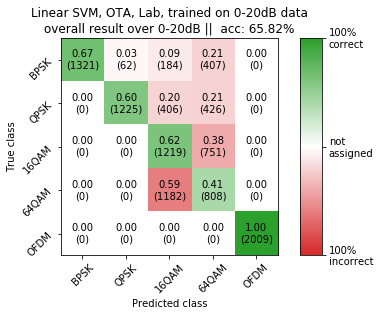

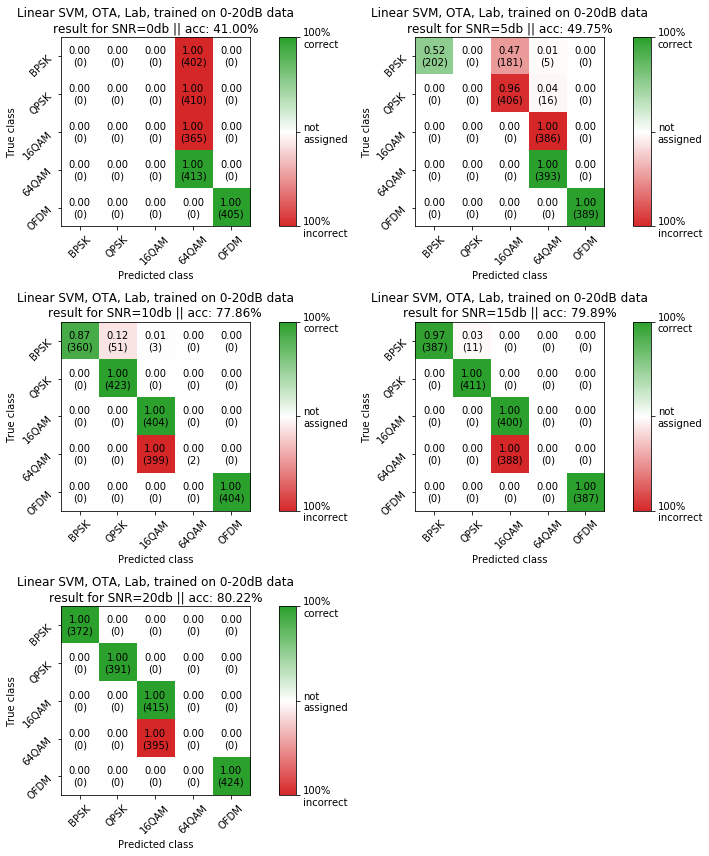

0-20dB  | 0dB     | 5dB     | 10dB    | 15dB    | 20dB    |
 65.82% |  41.00% |  49.75% |  77.86% |  79.89% |  80.22% | 


In [91]:
# evaluate training on 20dB data
results = {}
y_pred = ksvc_lab_20.predict(X_test)

# overall score
conf = confusion_matrix(le.inverse_transform(y_test_values),
                        le.inverse_transform(y_pred), 
                        labels=mods)

plot_confusion2(conf, mods, title = "Linear SVM, OTA, Lab, trained on 0-20dB data\n"+
               "overall result over 0-20dB || ")

results['all'] = np.sum(np.diag(conf)) / np.sum(conf)

# score for each SNR level
fig = plt.figure(figsize=(10, 12), facecolor='white')
gs = gridspec.GridSpec(3, 2)
cells = product(np.arange(3), np.arange(2))

for snr in ["0db", "5db", "10db", "15db", "20db"]:
    _y_test_values = y_test_values[y_test['snr_class'] == snr]
    _y_pred = y_pred[y_test['snr_class'] == snr]
    conf = confusion_matrix(le.inverse_transform(_y_test_values),
                            le.inverse_transform(_y_pred), 
                            labels=mods)
    plot_confusion2(conf, mods, gs[next(cells)], 
                   "Linear SVM, OTA, Lab, trained on 0-20dB data\n"+
                   "result for SNR=%s ||" % snr)
    
    results[snr] = np.sum(np.diag(conf)) / np.sum(conf)
    
plt.tight_layout()
plt.show()
print_results(results)

<hr style="background-color: black; height: 3px">
# Result


|          | 0-20dB | 0dB     | 5dB     | 10dB    | 15dB    | 20dB    |
|----------|--------|---------|---------|---------|---------|---------|
| all SNR  | 98.25% |  91.44% |  99.61% | 100.00% | 100.00% | 100.00% | 
| 20dB SNR | 67.76% |  40.67% |  56.78% |  80.31% |  80.39% |  80.08% | 

<hr style="background-color: blue; height: 5px">
# <span style=color:blue> SVM on Software-Defined Radios <span>


multiclass support is handled according to a one-vs-the-rest scheme, thus training n_class models.

**We test one scenario:**
1. How well does a SVM trained on 0-20dB data do
    1. on 0-20dB data?
    2. on 0,5,10,15,20 dB data?
    
<hr>

### Prepare data

In [78]:
# Prepare data

# label encoder
le = preprocessing.LabelEncoder().fit(mods)

# all SNR classes
dfi_all = database_select({
    'connection': 'ota',
    'cfo': 'no_cfo',
    'transmitter': 'usrp',
    'receiver': 'usrp',
})

# training set all SNR
X_train, X_test, y_train, y_test = train_test_split(
    dfi_all['X'], dfi_all['y'], test_size=10000, random_state=0)

X_train_all = X_train.iloc[:10000,:]
y_train_all = y_train.iloc[:10000,:]['mod']
y_train_all = le.transform(y_train_all.ravel())

# test set
y_test_values = y_test['mod']
y_test_values = le.transform(y_test_values.ravel())

print("Generated datasets:")
print("Training data (0-20dB):\t%d samples" % y_train_all.size)
print("Test data (0-20dB):\t%d samples" % y_test_values.size)

Remaining, non-unique columns: ['snr_class', 'mod_type', 'mod']
Generated datasets:
Training data (0-20dB):	10000 samples
Test data (0-20dB):	10000 samples


### Train SVM

In [79]:
# train svms

ksvc_sdr = SVC(C=10.0, kernel='linear', degree=2, gamma='auto', coef0=0.0, 
           shrinking=True, probability=False, tol=0.00001, cache_size=1000, 
           max_iter=-1, decision_function_shape='ovr', random_state=0).fit(X_train_all, y_train_all)

print("Training done -> ksvc_sdr")

Training done -> ksvc_sdr


### Evaluate SVM: Training SDR data

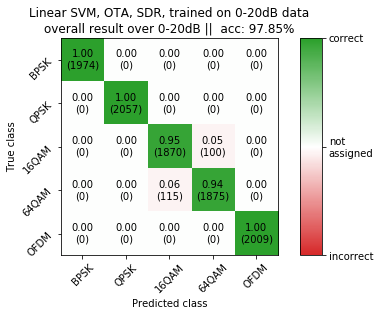

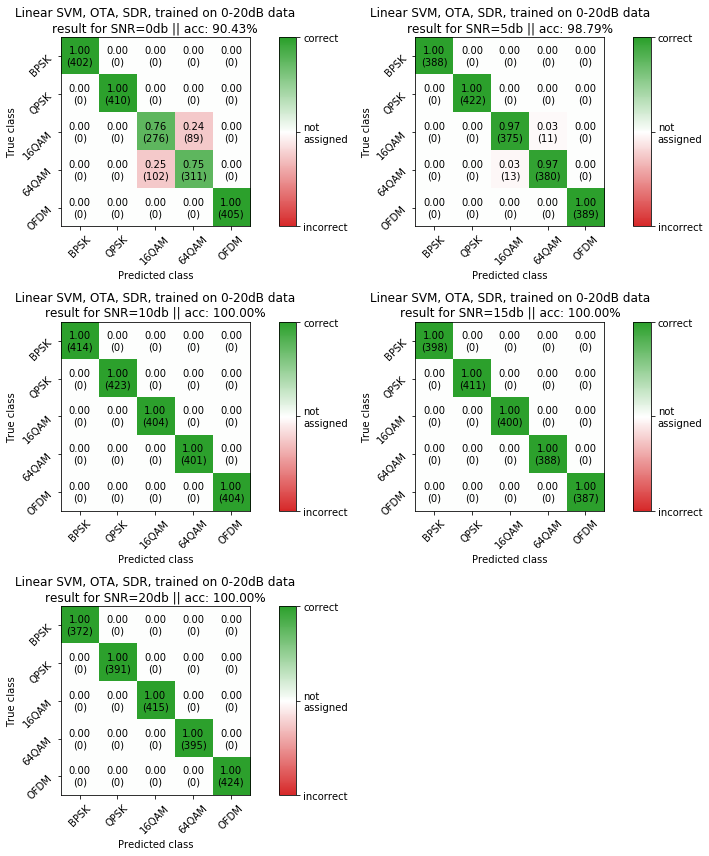

0-20dB  | 0dB     | 5dB     | 10dB    | 15dB    | 20dB    |
 97.85% |  90.43% |  98.79% | 100.00% | 100.00% | 100.00% | 


In [82]:
# evaluate training on SDR data
results = {}
y_pred = ksvc_sdr.predict(X_test)

# overall score
conf = confusion_matrix(le.inverse_transform(y_test_values),
                        le.inverse_transform(y_pred), 
                        labels=mods)

plot_confusion2(conf, mods, title = "Linear SVM, OTA, SDR, trained on 0-20dB data\n"+
               "overall result over 0-20dB || ")

results['all'] = np.sum(np.diag(conf)) / np.sum(conf)

# score for each SNR level
fig = plt.figure(figsize=(10, 12), facecolor='white')
gs = gridspec.GridSpec(3, 2)
cells = product(np.arange(3), np.arange(2))

for snr in ["0db", "5db", "10db", "15db", "20db"]:
    _y_test_values = y_test_values[y_test['snr_class'] == snr]
    _y_pred = y_pred[y_test['snr_class'] == snr]
    conf = confusion_matrix(le.inverse_transform(_y_test_values),
                            le.inverse_transform(_y_pred), 
                            labels=mods)
    plot_confusion2(conf, mods, gs[next(cells)], 
                   "Linear SVM, OTA, SDR, trained on 0-20dB data\n"+
                   "result for SNR=%s ||" % snr)

    results[snr] = np.sum(np.diag(conf)) / np.sum(conf)
    
plt.tight_layout()
plt.show()
print_results(results)

<hr style="background-color: black; height: 3px">
# Result


|     | 0-20dB | 0dB     | 5dB     | 10dB    | 15dB    | 20dB    |
|-----|--------|---------|---------|---------|---------|---------|
| LAB | 98.25% |  91.44% |  99.61% | 100.00% | 100.00% | 100.00% | 
| SDR | 97.85% |  90.43% |  98.79% | 100.00% | 100.00% | 100.00% | 

<hr style="background-color: blue; height: 5px">
# <span style=color:blue>SVM on CFO</span>

### Prepare data

**Prepare two datasets**

1. training + test set with up to 1ppm CFO
2. training + test set with up to 5ppm CFO

In [83]:
# Prepare data

# label encoder
le = preprocessing.LabelEncoder().fit(mods)

dfi_1 = database_select({
    'connection': 'ota',
    'cfo': '1ppm',
    'transmitter': 'vsg',
    'receiver': 'sa',
})

dfi_5 = database_select({
    'connection': 'ota',
    'cfo': '5ppm',
    'transmitter': 'vsg',
    'receiver': 'sa',
})

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    dfi_1['X'], dfi_1['y'], test_size=10000, random_state=0)

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(
    dfi_5['X'], dfi_5['y'], test_size=10000, random_state=0)

X_train_1 = X_train_1.iloc[:10000,:]
y_train_1 = y_train_1.iloc[:10000,:]['mod']
y_train_1 = le.transform(y_train_1.ravel())

X_train_5 = X_train_5.iloc[:10000,:]
y_train_5 = y_train_5.iloc[:10000,:]['mod']
y_train_5 = le.transform(y_train_5.ravel())

y_test_1_values = y_test_1['mod']
y_test_1_values = le.transform(y_test_1_values.ravel())

y_test_5_values = y_test_5['mod']
y_test_5_values = le.transform(y_test_5_values.ravel())

print("Generated datasets:")
print("Training data (1ppm):\t%d samples" % y_train_1.size)
print("Test data (1ppm):\t%d samples" % y_test_1_values.size)
print("Training data (5ppm):\t%d samples" % y_train_5.size)
print("Test data (5ppm):\t%d samples" % y_test_5_values.size)

Remaining, non-unique columns: ['snr_class', 'mod_type', 'mod']
Remaining, non-unique columns: ['snr_class', 'mod_type', 'mod']
Generated datasets:
Training data (1ppm):	10000 samples
Test data (1ppm):	10000 samples
Training data (5ppm):	10000 samples
Test data (5ppm):	10000 samples


### Train SVM

In [84]:
# train svms

ksvc_1 = SVC(C=10.0, kernel='linear', degree=2, gamma='auto', coef0=0.0, 
           shrinking=True, probability=False, tol=0.00001, cache_size=1000, 
           max_iter=-1, decision_function_shape='ovr', random_state=0).fit(X_train_1, y_train_1)

print("Training done -> ksvc_1")

ksvc_5 = SVC(C=10.0, kernel='linear', degree=2, gamma='auto', coef0=0.0, 
           shrinking=True, probability=False, tol=0.00001, cache_size=1000, 
           max_iter=-1, decision_function_shape='ovr', random_state=0).fit(X_train_5, y_train_5)

print("Training done -> ksvc_5")

Training done -> ksvc_1
Training done -> ksvc_5


### Evaluate SVM on 1ppm

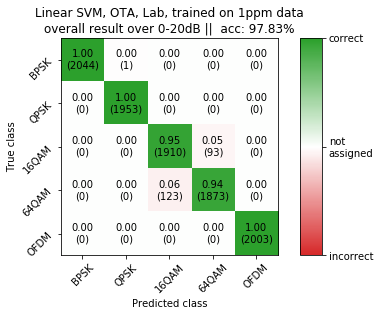

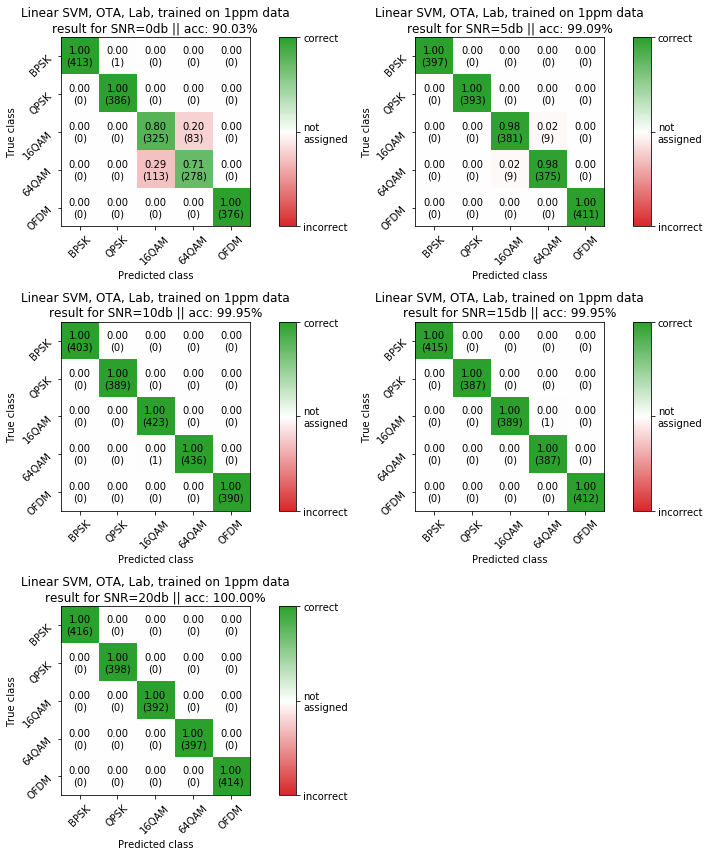

0-20dB  | 0dB     | 5dB     | 10dB    | 15dB    | 20dB    |
 97.83% |  90.03% |  99.09% |  99.95% |  99.95% | 100.00% | 


In [88]:
# evaluate training on 1ppm
results = {}
y_pred = ksvc_1.predict(X_test_1)

# overall score
conf = confusion_matrix(le.inverse_transform(y_test_1_values),
                        le.inverse_transform(y_pred), 
                        labels=mods)

plot_confusion2(conf, mods, title = "Linear SVM, OTA, Lab, trained on 1ppm data\n"+
               "overall result over 0-20dB || ")

results['all'] = np.sum(np.diag(conf)) / np.sum(conf)

# score for each SNR level
fig = plt.figure(figsize=(10, 12), facecolor='white')
gs = gridspec.GridSpec(3, 2)
cells = product(np.arange(3), np.arange(2))

for snr in ["0db", "5db", "10db", "15db", "20db"]:
    _y_test_values = y_test_1_values[y_test_1['snr_class'] == snr]
    _y_pred = y_pred[y_test_1['snr_class'] == snr]
    conf = confusion_matrix(le.inverse_transform(_y_test_values),
                            le.inverse_transform(_y_pred), 
                            labels=mods)
    plot_confusion2(conf, mods, gs[next(cells)], 
                   "Linear SVM, OTA, Lab, trained on 1ppm data\n"+
                   "result for SNR=%s ||" % snr)

    results[snr] = np.sum(np.diag(conf)) / np.sum(conf)
    
plt.tight_layout()
plt.show()
print_results(results)

### Evaluate SVM on 5ppm

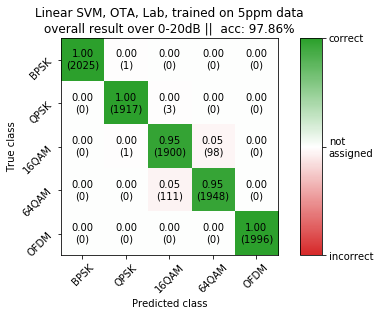

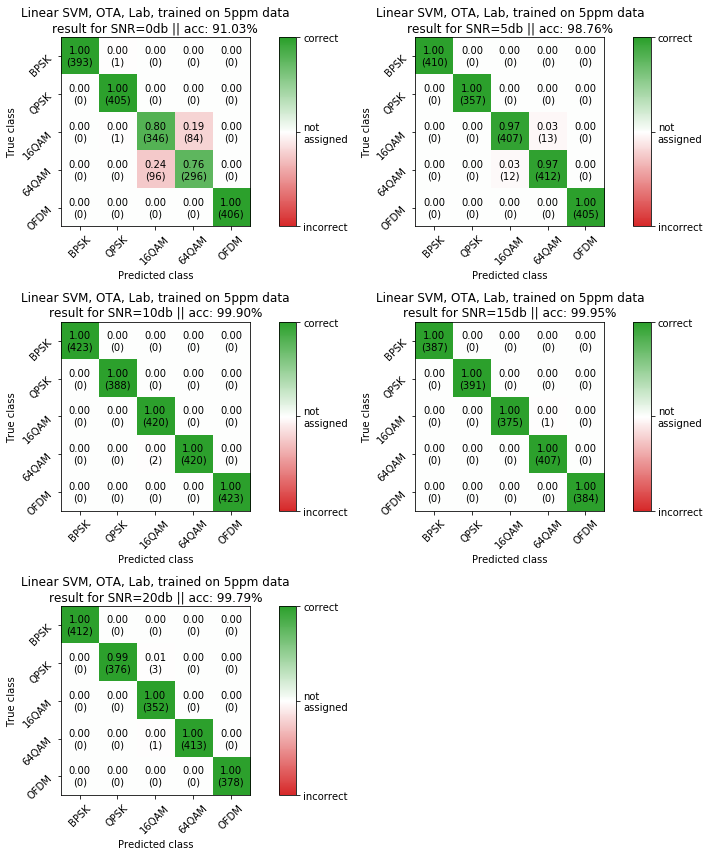

0-20dB  | 0dB     | 5dB     | 10dB    | 15dB    | 20dB    |
 97.86% |  91.03% |  98.76% |  99.90% |  99.95% |  99.79% | 


In [89]:
# evaluate training on 5ppm
results = {}
y_pred = ksvc_5.predict(X_test_5)

# overall score
conf = confusion_matrix(le.inverse_transform(y_test_5_values),
                        le.inverse_transform(y_pred), 
                        labels=mods)

plot_confusion2(conf, mods, title = "Linear SVM, OTA, Lab, trained on 5ppm data\n"+
               "overall result over 0-20dB || ")

results['all'] = np.sum(np.diag(conf)) / np.sum(conf)

# score for each SNR level
fig = plt.figure(figsize=(10, 12), facecolor='white')
gs = gridspec.GridSpec(3, 2)
cells = product(np.arange(3), np.arange(2))

for snr in ["0db", "5db", "10db", "15db", "20db"]:
    _y_test_values = y_test_5_values[y_test_5['snr_class'] == snr]
    _y_pred = y_pred[y_test_5['snr_class'] == snr]
    conf = confusion_matrix(le.inverse_transform(_y_test_values),
                            le.inverse_transform(_y_pred), 
                            labels=mods)
    plot_confusion2(conf, mods, gs[next(cells)], 
                   "Linear SVM, OTA, Lab, trained on 5ppm data\n"+
                   "result for SNR=%s ||" % snr)

    results[snr] = np.sum(np.diag(conf)) / np.sum(conf)
    
plt.tight_layout()
plt.show()
print_results(results)

<hr style="background-color: black; height: 3px">
# Result

|          | 0-20dB | 0dB     | 5dB     | 10dB    | 15dB    | 20dB    |
|----------|--------|---------|---------|---------|---------|---------|
| 0ppm     | 98.25% |  91.44% |  99.61% | 100.00% | 100.00% | 100.00% | 
| 1ppm     | 97.83% |  90.03% |  99.09% |  99.95% |  99.95% | 100.00% | 
| 5ppm     | 97.86% |  91.03% |  98.76% |  99.90% |  99.95% |  99.79% | 

<hr style="background-color: blue; height: 5px">
# <span style=color:blue>SVM on different training and sample lengths</span>


In [7]:
# analyze training and sample lengths

# create Dataframe for result
num_syms = [10000, 5000, 1000, 500, 100]
num_smps = [10000, 5000, 1000, 500, 100]
indicies = ["0-20db", "0db", "5db", "10db", "15db", "20db"]
columns = pd.MultiIndex.from_product([num_syms, num_smps], names=["#symbols", "#samples"])
results = pd.DataFrame(index=indicies, columns=columns)
display(results)

sys.exit(0)

# label encoder
le = preprocessing.LabelEncoder().fit(mods)

for num_sym in [10000, 5000, 1000, 500, 100]: # number of symbols (recording length)
    
    dfi = database_select({
        'connection': 'ota',
        'cfo': 'no_cfo',
        'transmitter': 'vsg',
        'receiver': 'sa',
        'symbols': num_sym,
    })
    
    X_train, X_test, y_train, y_test = train_test_split(
        dfi['X'], dfi['y'], test_size=10000, random_state=0)
    y_test_values = y_test['mod']
    y_test_values = le.transform(y_test_values.ravel())
    
    for num_smp in [10000, 5000, 1000, 500, 100]: # number of samples (during training)
        
        X_train = X_train.iloc[:num_smp,:]
        y_train = y_train.iloc[:num_smp,:]['mod']
        y_train = le.transform(y_train.ravel())
        
        # train SVM
        ksvc = SVC(C=10.0, kernel='linear', degree=2, gamma='auto', coef0=0.0, 
           shrinking=True, probability=False, tol=0.00001, cache_size=1000, 
           max_iter=-1, decision_function_shape='ovr', random_state=0).fit(X_train, y_train)
        
        # evaluate SVM
        results.loc['0-20db', (num_sym, num_smp)] = score(X_test, y_test_values) 
        for snr in ["0db", "5db", "10db", "15db", "20db"]:
            _y_test_values = y_test_values[y_test['snr_class'] == snr]
            _X_test = X_test[y_test['snr_class'] == snr]
            results.loc[snr, (num_sym, num_smp)] = score(X_test, y_test_values) 

results.index = ["0-20dB", "0dB", "5dB", "10dB", "15dB", "20dB"]

display(results)

#symbols 10000                         5000                           ...   \
#samples 10000 5000  1000  500   100   10000 5000  1000  500   100    ...    
0-20dB     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
0dB        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
5dB        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
10dB       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
15dB       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
20dB       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    

#symbols 500                           100                            
#samples 10000 5000  1000  500   100   10000 5000  1000  500   100    
0-20dB     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
0dB        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5dB        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
10dB       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
15dB       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
20dB       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[6 rows x 25 columns]

SystemExit: 0

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<hr style="background-color: black; height: 3px">
# Result

|           | 10000 smp |  5000 smp |  1000 smp |   500 smp |   100 smp |
|-----------|-----------|-----------|-----------|-----------|-----------|
| 10000 sym |           |           |           |           |           |
| 5000 sym  |           |           |           |           |           |
| 1000 sym  |           |           |           |           |           |
| 500 sym   |           |           |           |           |           |
| 100 sym   |           |           |           |           |           |

<hr style="background-color: blue; height: 5px">
# <span style=color:blue>SVM on different pulse-shape filters</span>

<hr style="background-color: blue; height: 5px">
# <span style=color:blue>SVM on new modulation scheme</span>

<hr style="background-color: blue; height: 5px">
<hr style="background-color: black; height: 5px">
<hr style="background-color: blue; height: 5px">
# <span style=color:blue>SVM on Interference</span>

<hr>
<hr>
<hr>
# Gridsearch (test)

In [ ]:
import os
os._exit(0)

In [ ]:
# gridsearch test

import sys
sys.path.append('../')

from init import *
from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

if __name__ == "__main__":

    # get data 
    dfi = df.copy()
    dfi = dfi[dfi['y', 'connection'] == 'ota']
    dfi = dfi[dfi['y', 'mod_type'] == 'SC']
    dfi = dfi.iloc[:10000, :]
    
    X_train, X_test, y_train, y_test = train_test_split(dfi['X'], dfi['y'], test_size=5000, random_state=0)
    y_train = y_train['mod'].ravel()
    y_test = y_test['mod'].ravel()

    le = preprocessing.LabelEncoder().fit(y_train)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    
    # Set the parameters by cross-validation
    unchanged_params = {
        'max_iter': [-1],
        'tol': [0.0001],
        'C': np.logspace(-1,2,10), #5
        'shrinking': [True],
        'cache_size': [1000.0],
        'random_state': [0],
    }
    lsvm_parameters = [
        {
            **unchanged_params,
            'kernel': ['linear'],
        },
        {
            **unchanged_params,
            'kernel': ['poly'],
            'degree': [1,2,3],
            'gamma' : np.logspace(-0.5,1.6,5)*(1/y_train.shape[0]), #5
            'coef0' : np.linspace(0,10,5)
            
        },
        {
            **unchanged_params,
            'kernel': ['rbf'],
            'gamma' : np.logspace(-0.5,1.6,5)*(1/y_train.shape[0]), #5
            
        }
    ]

    # run grid search
    clf = GridSearchCV(SVC(), lsvm_parameters, cv=5, scoring='accuracy', 
                       n_jobs=12*6, return_train_score=True, verbose=2)
    clf.fit(X_train, y_train)
    
    # show and save results
    cv_results = pd.DataFrame(clf.cv_results_).sort_values('mean_test_score', ascending=False)
    print(pd.DataFrame(cv_results.iloc[:, 2:-16]))
    print("Best params: ", clf.best_params_)
    
    with open('results/linear_svc.pkl', 'wb') as pickle_file:
        pickle.dump(
            {
                'cv_results': cv_results,
                'best_params': clf.best_params_,
                'best_estimator': clf.best_estimator_,
                
            }, pickle_file)
